In [1]:
#%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor
# load some utilities (for loading MNIST and plotting)
# also imports most Python modules
_#%run utils.py

# load MNIST training and test data sets
train_dataset = datasets.MNIST(
  root = 'data',
  train = True,                         
  transform = ToTensor(), 
  download = True,            
  )
test_dataset = datasets.MNIST(
  root = 'data', 
  train = False, 
  transform = ToTensor()
  )

train_data = train_dataset.data/255
train_labels = train_dataset.targets

train_images = train_dataset.data/255
train_labels = train_dataset.targets

test_images = test_dataset.data/255
test_labels = test_dataset.targets

# Variational Autoencoder

Is it reasonable to assume that we can generate images similar to the ones in the MNIST data set by a linear transformation of low dimensional latent variables?

Let us reflect on the limitations of PCA and PPCA. In both models, data is encoded in a lower dimensional space by a linear (or rather affine) transformation, and the lower dimensional representation can be decoded
by another affine function. One implication is that relative distances are preserved between the original space and the lower-dimensional latent space: if two data samples are "close" to each other, then also their latent encodings are relatively "close" to each other, and similarly two latent encodings that are "close" to each other are decoded to two relatively "close" data points. This affects our ability to reconstruct images from their encodings and to generate new images.

Let us consider a more flexible non-linear model that is given by 
\begin{align*}
  p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z}) &= \mathcal{N}\left(\mathbf{x}; \mu_{\boldsymbol{\theta}}(\mathbf{z}), \sigma_{\boldsymbol{\theta}}^2 \mathbf{I}_{784}\right), \\
  p_{\boldsymbol{\theta}}(\mathbf{z}) &= \mathcal{N}(\mathbf{z}; \boldsymbol{0}, \mathbf{I}_2),
\end{align*}
where parameters $\boldsymbol{\theta}$ include variance parameter $\sigma^2_{\boldsymbol{\theta}} > 0$ and $\mu_{\boldsymbol{\theta}} \colon \mathbb{R}^2 \to \mathbb{R}^{784}$ is a nonlinear model of the mean of the normal distribution. In this lab we model $\mu_{\boldsymbol{\theta}}$ by a neural network and include its weights and biases in $\boldsymbol{\theta}$, but other models could be used equally well.

This nonlinear model looks similar to the PPCA model above. However, in contrast to the PPCA model, for most classes of functions $\mu_{\boldsymbol{\theta}}$ the marginal distribution of $\mathbf{x}$ is not a normal distribution anymore, and typically there exists not even a closed form expression for its density.
Thus usually we can not learn the parameters $\boldsymbol{\theta}$ in the same straightforward way as for the PPCA model by minimizing the negative log-likelihood with gradient descent.

https://mustafaghali11.medium.com/how-pytorch-backward-function-works-55669b3b7c62

## Training: Variational autoencoder

### Introduction

There are at least two problems with the nonlinear model and our training procedure so far:
- For most samples of
$\mathbf{z}$, $p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z})$ is almost zero. Hence these
terms will not contribute much to the estimation of $p_{\boldsymbol{\theta}}(\mathbf{x})$,  which can slow down the training procedure.
- An even more fundamental problem with the nonlinear model is the fact that
usually we can not compute an analytical expression for
$p_{\boldsymbol{\theta}}(\mathbf{z} \,|\, \mathbf{x})$. Thus we can not encode
data in the lower dimensional latent space and analyze its structure.

The main idea of a so-called variational autotoencoder (VAE) is to resolve the first issue by attempting to obtain samples
$\mathbf{z}$ for which $p_{\boldsymbol{\theta}}(\mathbf{x} \,|\, \mathbf{z})$ is large.

## ELBO

When diving into the world of machine learning, especially with complex models like Variational Autoencoders (VAEs), we encounter the challenge of understanding how these models learn to compress and recreate data. The ELBO is a key concept that helps in this learning process. Here’s a breakdown that includes both the intuition and the math behind it.

#### The Essence of ELBO

The ELBO serves as a bridge connecting our data with its simpler, more manageable representation (latent variables). It's like finding a secret code that captures the essence of our data but in a much simpler form. The magic lies in how we score and improve this "coding" process.

#### Breaking Down the ELBO

- **Encoding Distribution $\left(q_{\phi}(\mathbf{z}; \mathbf{x})\right)$:** This formula represents our guess on how to encode (or summarize) our data into latent variables, based on the data $\left(\mathbf{x}\right)$ and parameters $\left(\phi\right)$.

- **Reconstruction Quality:** The first part of the ELBO equation,
$$
\mathbb{E}_{\mathbf{z} \sim q_{\phi}(\mathbf{z}; \mathbf{x})}\left[\log p_{\theta}(\mathbf{x} | \mathbf{z})\right],
$$
measures how well we can reconstruct the original data from these latent variables. A higher score means our summaries are detailed and accurate.

- **Regularity of Summaries:** The next parts involve KL divergence,
$$
\mathrm{KL}\left(q_{\phi}(\mathbf{z}; \mathbf{x}) \,\big\|\, p_{\theta}(\mathbf{z} \,|\,\mathbf{x})\right) - \mathrm{KL}\left(q_{\phi}(\mathbf{z}; \mathbf{x}) \,\big\|\, p_{\theta}(\mathbf{z})\right),
$$
which ensures that our latent variables (summaries) aren't just random but follow a predictable, organized pattern. This regularization helps in maintaining a structure within our model's understanding of the data.

- **ELBO Simplified:** The KL divergence of two distributions is always non-negative, and zero if and only if the two distributions are equal. Hence we have for all $\mathbf{x}$:
$$
\log p_{\theta}(\mathbf{x}) \geq \mathbb{E}_{\mathbf{z} \sim q_{\phi}(\mathbf{z}; \mathbf{x})}\left[\log p_{\theta}(\mathbf{x} | \mathbf{z})\right] - \mathrm{KL}\left[q_{\phi}(\mathbf{z}; \mathbf{x}) \| p_{\theta}(\mathbf{z})\right],
$$
where we focus on maximizing this lower bound to train our model effectively.

#### The Insight

What this equation beautifully reveals is a balance: we’re trying to get the best of both worlds. We want to accurately reconstruct our data while also ensuring our encoded summaries make sense within the predefined structure (the model's architecture and assumptions).

#### The Analytical Perk

A helpful aspect of the ELBO is that part of it,
$$
\mathrm{KL}\left(q_{\phi}(\mathbf{z}; \mathbf{x}) \,\|\, p_{\theta}(\mathbf{z})\right),
$$
can often be computed directly. This part compares our encoding distribution to a standard form (like a normal distribution), simplifying how we measure the model's efficiency.

#### Conclusion

In essence, the ELBO helps guide our model to learn an efficient, compact representation of data. By maximizing the ELBO, we fine-tune this learning process, ensuring our model not only captures the intricacies of our data but also organizes this information in a coherent, structured manner. It's a cornerstone concept in making models like VAEs practical and powerful tools for understanding and generating complex data.



### Fine-Tuning Our Data's "Secret Code": The Encoding Distribution

To better grasp the Variational Autoencoder (VAE) and its workings, let's delve into the concept of choosing a specific encoding distribution. This choice is akin to selecting the best way to summarize our data into its hidden, more manageable form.

#### The Mathematical Essence

When we talk about encoding our data, we use a specific mathematical model:

$$
q_{\phi}(\mathbf{z}; \mathbf{x}) = \mathcal{N}(\mathbf{z}; \mu_{\phi}(\mathbf{x}), \mathrm{diag}(\sigma_{\phi}^2(\mathbf{x})))
$$

Here, $\left(\mu_{\phi}(\mathbf{x})\right)$ represents the mean—essentially, the central point of our summaries, and $\left(\sigma_{\phi}^2(\mathbf{x})\right)$ are the variances—how much we allow our summaries to deviate from the mean. Think of it as deciding the main theme of a story and how much detail from the original to keep or omit.

#### ELBO Unpacked

With our chosen encoding distribution, the ELBO transforms into:

$$
\mathbb{E}_{\mathbf{z} \sim \mathcal{N}(\mathbf{z}; \mu_{\phi}(\mathbf{x}), \mathrm{diag}(\sigma_{\phi}^2(\mathbf{x})))}\big[\log p_{\theta}(\mathbf{x} \,|\, \mathbf{z})\big] - \frac{1}{2} \left(\sum_{n=1}^2 (\sigma_{\phi}^2(\mathbf{x}))_n + \|\mu_{\phi}(\mathbf{x})\|^2_2 - 2 - \sum_{n=1}^2 \log (\sigma_{\phi}^2(\mathbf{x}))_n\right),
$$

This equation captures the balance between accurately reconstructing our data from its summaries and keeping those summaries within a reasonable, structured framework.

#### The Power of Monte Carlo

To approximate this balance, we employ the Monte Carlo estimate:

$$
\frac{1}{K} \sum_{n=1}^K \log p_{\theta}(\mathbf{x} \,|\, \mathbf{z}_n) - \frac{1}{2} \left(\sum_{n=1}^2 (\sigma_{\phi}^2(\mathbf{x}))_n + \|\mu_{\phi}(\mathbf{x})\|^2_2 - 2 - \sum_{n=1}^2 \log (\sigma_{\phi}^2(\mathbf{x}))_n\right),
$$

where we take multiple samples from our encoding distribution to see how well we can reconstruct the original data. It's like testing different summaries to see which one tells the story best.

#### The Ultimate Goal: Tuning for Better Summaries

Our aim is to adjust $\left(\phi\right)$ (how we encode) and $\left(\theta\right)$ (how we decode) to make our data's reconstruction as accurate as possible. If our encoding is flexible enough, it can match the true complexity of our data, making our ELBO as close as possible to the actual data likelihood.

#### The Path to Perfect Encoding

Additionally, if we manage that distribution $\left(q\right)$ becomes equal to the distribution $\left(p_{\theta}(\mathbf{z} \,|\, \mathbf{x})\right)$ (or at least close to it), we have found a way to encode our data: for a given data sample $\left(\mathbf{x}\right)$, we can just sample the latent encoding from $\left(q_{\phi}(\mathbf{z}; \mathbf{x})\right)$. So by introducing the encoding distribution and maximizing the ELBO, we might be able to solve both problems of the nonlinear model.

#### The Takeaway

What this boils down to is a sophisticated dance of adjustment and balance. By carefully selecting and tuning our encoding distribution, we enhance the VAE's ability to not just mimic but deeply understand our data. This process of maximizing the ELBO, therefore, isn't just about making guesses; it's about refining our guesses to the point where they reveal the true structure and essence of the data we're exploring.



### Cost Function: Navigating Through the Learning Landscape

With our set of training data, we're not just wandering in the dark; we have a map—the cost function. This function quantifies how well our model is performing, guiding us towards the best version of our data's encoding and decoding.

#### Summing Up the Data's Story

For our entire collection of training data $\left(\mathbf{x}_1, \ldots, \mathbf{x}_N\right)$, the story of our model's performance unfolds as follows:

\begin{equation*}
    \begin{split}
    \log p_{\theta}(\mathbf{x}_1, \ldots, \mathbf{x}_N) &= \sum_{n=1}^N \log p_{\theta}(\mathbf{x}_n) \\
    &\geq \sum_{n=1}^N \mathbb{E}_{\mathbf{z} \sim \mathcal{N}(\mathbf{z}; \mu_{\phi}(\mathbf{x}_n), \mathrm{diag}(\sigma_{\phi}^2(\mathbf{x}_n)))}\big[\log p_{\theta}(\mathbf{x}_n \,|\, \mathbf{z})\big] \\
   &\quad - \frac{1}{2} \sum_{n=1}^N \left(\sum_{i=1}^2 (\sigma_{\phi}^2(\mathbf{x}_n))_i + \|\mu_{\phi}(\mathbf{x}_n)\|^2_2 - 2 - \sum_{i=1}^2 \log (\sigma_{\phi}^2(\mathbf{x}_n))_i\right),
    \end{split}
\end{equation*}

This equation tells us that our model's log-likelihood (how likely it is to see our training data) is at least as large as the value given by the equation. It's a combination of how well we can recreate each data point from its encoded form and a penalty for how "expensive" our encoding choices are.

#### Joint ELBO: A Collective Measure

We estimate the joint ELBO, which aggregates our model's performance across all data points, offering a comprehensive view:

$$
    \begin{split}
     & \sum_{n=1}^N \frac{1}{K} \sum_{n'=1}^K \log p_{\theta}(\mathbf{x}_n \,|\, \mathbf{z}_{n,n'})
  - \frac{1}{2} \sum_{n=1}^N \left(\sum_{i=1}^2 (\sigma_{\phi}^2(\mathbf{x}_n))_i + \|\mu_{\phi}(\mathbf{x}_n)\|^2_2 - 2 - \sum_{i=1}^2 \log (\sigma_{\phi}^2(\mathbf{x}))_i\right) \\
     ={}& - \frac{1}{2}\left(784 N \left(\log{(2\pi)} + \log{\sigma_{\theta}^2})\right) + \frac{1}{\sigma_{\theta}^2}\sum_{n=1}^N \frac{1}{K} \sum_{n'=1}^K \|\mu_{\theta}(\mathbf{z}_{n,n'}) - \mathbf{x}_n\|^2_2 \right) \\
     & - \frac{1}{2} \sum_{n=1}^N \left(\sum_{i=1}^2 (\sigma_{\phi}^2(\mathbf{x}_n))_i + \|\mu_{\phi}(\mathbf{x}_n)\|^2_2 - 2 - \sum_{i=1}^2 \log (\sigma_{\phi}^2(\mathbf{x}_n))_i\right),
     \end{split}
$$

This gives us a method to evaluate our model's ability to reconstruct the training data from the latent encodings, adjusted for the complexity of our encoding strategy.

#### Simplifying the Journey: The Cost Function

In the realm of stochastic optimization, we often simplify our approach by taking just one sample $(K = 1)$ for each piece of data. This leads us to a practical cost function for adjusting our model:

\begin{equation*}
        J(\theta, \phi) = \text{Constant Term} + \text{Reconstruction Term} + \text{KL Divergence Term}
\end{equation*}
Where:

- **Constant Term:**            $784 \log{\sigma_{\theta}^2} $
- **Reconstruction Term:**      $\frac{1}{N \sigma_{\theta}^2} \sum_{n=1}^N  \|\mu_{\theta}(\mathbf{z}_n) - \mathbf{x}_n\|^2_2$
- **KL Divergence Term:**       $\frac{1}{N} \sum_{n=1}^N \left(\sum_{i=1}^2 (\sigma_{\phi}^2(\mathbf{x}_n))_i + \|\mu_{\phi}(\mathbf{x}_n)\|^2_2 - \sum_{i=1}^2 \log (\sigma_{\phi}^2(\mathbf{x}_n))_i\right)$.

Substituting these components back into the equation gives:

\begin{equation*}
        J(\theta, \phi) = 784 \log{\sigma_{\theta}^2} + \frac{1}{N \sigma_{\theta}^2} \sum_{n=1}^N  \|\mu_{\theta}(\textcolor{red}{\mathbf{z}_n}) - \mathbf{x}_n\|^2_2 + \frac{1}{N} \sum_{n=1}^N \left(\sum_{i=1}^2 (\sigma_{\phi}^2(\mathbf{x}_n))_i + \|\mu_{\phi}(\mathbf{x}_n)\|^2_2 - \sum_{i=1}^2 \log (\sigma_{\phi}^2(\mathbf{x}_n))_i\right),
\end{equation*}
where $\left(\textcolor{red}{\mathbf{z}_n}\right)$ are independent samples from the encoding distribution $\left(\mathcal{N}(\mathbf{z}; \mu_{\phi}(\mathbf{x}_n), \mathrm{diag}(\sigma_{\phi}^2(\mathbf{x}_n)))\right)$. We will minimize this cost function with stochastic gradient descent.

#### Strategic Simplification for Efficiency

Choosing $\left(K = 1\right)$ reflects a strategic simplification, leveraging the power of stochastic optimization. It allows us to efficiently navigate the model's learning process by focusing on individual data points, one at a time, rather than the entire dataset at once. This approach not only makes the optimization more tractable but also introduces a beneficial level of randomness that can help avoid local minima.

#### The End Goal: A Harmonious Model

Minimizing this cost function is our guiding light through the complex terrain of model training. It directs us towards the sweet spot where our model achieves a harmonious balance: accurately reconstructing data while maintaining a simple, yet expressive, latent representation. Through the iterative process of stochastic gradient descent, we gradually refine the parameters $\left(\theta\right)$ and $\left(\phi\right)$, honing in on the optimal way to encode and decode our world of data.

In essence, the journey through the landscape shaped by the cost function is a path towards understanding. It's how we teach our model to see the underlying structure of the data, to grasp its essence, and to reproduce it with fidelity and clarity. This is the heart of learning in Variational Autoencoders.

### Reparameterization Trick: Navigating Through Differentiation Challenges

One of the clever innovations in the training of Variational Autoencoders (VAEs) is overcoming a particular hurdle: how do we adjust our model's parameters based on something as unpredictable as sampling? This challenge emerges when we try to learn from our encoded representations $(\mathbf{z}_n)$.

#### The Challenge at Hand

Traditionally, differentiating through a sampling operation is tricky because sampling introduces randomness that doesn't directly link back to the parameters $(\phi)$ that set the stage for the distribution we sample from. Essentially, we're trying to learn from the outcomes of a dice roll without knowing how to trace the effects of each roll back to the dice's design.

#### A Clever Solution

The reparameterization trick offers a brilliant workaround. Instead of directly sampling our encoded representations $(\mathbf{z}_n)$ in a way that's hard to trace, we transform samples from a standard normal distribution through an affine operation. This means we can express our complex, parameter-dependent sampling in terms of simpler, parameter-independent samples:

\begin{equation*}
    \begin{split}
 J(\theta, \textcolor{blue}{\phi}) &= 784 \log{\sigma_{\theta}^2} + \frac{1}{N \sigma_{\theta}^2} \sum_{n=1}^N  \|\mu_{\theta}(\mu_{\textcolor{blue}{\phi}}(\mathbf{x}_n) + \mathrm{diag}(\sigma_{\textcolor{blue}{\phi}}(\mathbf{x}_n)) \textcolor{red}{\epsilon_n}) - \mathbf{x}_n\|^2_2 \\
 &\quad + \frac{1}{N} \sum_{n=1}^N \left(\sum_{i=1}^2 (\sigma_{\textcolor{blue}{\phi}}^2(\mathbf{x}_n))_i + \|\mu_{\textcolor{blue}{\phi}}(\mathbf{x}_n)\|^2_2 - \sum_{i=1}^2 \log (\sigma_{\textcolor{blue}{\phi}}^2(\mathbf{x}_n))_i\right),
 \end{split}
\end{equation*}

where $\textcolor{red}{\epsilon_n}$ are samples from the standard normal distribution $\mathcal{N}(\mathbf{0}, \mathbf{I}_2)$. This transformation allows us to maintain the stochastic nature of our model while making the connection to our parameters $(\textcolor{blue}{\phi})$ explicit and differentiable.

#### Why This Matters

By employing the reparameterization trick, we transform the problem of differentiating through randomness into a problem that's much more straightforward. Now, the randomness of our samples (\(\epsilon_n\)) doesn't obscure the path from output back to parameters. This means we can effectively train our model, adjusting the parameters (\(\phi\)) based on how well our model performs, with a clear understanding of how those adjustments affect the outcomes.

In essence, the reparameterization trick is a key that unlocks efficient and effective training for VAEs. It allows us to embrace the randomness essential to the model's design while providing a clear route for learning and improvement through backpropagation.

Was this written by an AI? Yes, yes it was...

We now consider the following nonlinear model, in which in addition to the nonlinear model above we also implement an encoding distribution. The mean and the logarithm of the diagonal entries of the covariance matrix of the encoding distribution are modeled by a shallow neural network, and the `encode` function returns them for a batch of inputs. As above, the `decode` function outputs the representative decoding for a batch of encodings.

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()

        # linear parts of the nonlinear encoder
        self.encoder_fc1 = nn.Linear(784, 400)
        self.encoder_fc2_mean = nn.Linear(400, 2)
        self.encoder_fc2_logsigma2 = nn.Linear(400, 2)

        # linear parts of the nonlinear function mu_phi
        self.decoder_fc1 = nn.Linear(2, 400)
        self.decoder_fc2 = nn.Linear(400, 784)

        # logarithm of variance sigma_phi^2
        self.logsigma2 = nn.Parameter(torch.zeros(1))

    def encode(self, x):
        h1 = F.relu(self.encoder_fc1(x))
        return self.encoder_fc2_mean(h1), self.encoder_fc2_logsigma2(h1)

    def decode(self, z):
        h1 = F.relu(self.decoder_fc1(z))
        return self.decoder_fc2(h1)

# Variational Autoencoder (VAE) Model Summary

This VAE model is implemented as a subclass of `nn.Module` in PyTorch, featuring an encoder-decoder architecture for generating and reconstructing data.

## Components

### Encoder
- **Purpose**: Maps input data to a latent space representation.
- **Layers**:
  - `encoder_fc1`: Linear transformation from input dimension (784) to an intermediate dimension (400).
  - `encoder_fc2_mean`: Linear layer that outputs the mean (`μ`) of the latent space representation (dimension: 2).
  - `encoder_fc2_logsigma2`: Linear layer that outputs the logarithm of the variance (`log(σ²)`) of the latent space representation (dimension: 2).

### Decoder
- **Purpose**: Maps latent space representations back to the original data space.
- **Layers**:
  - `decoder_fc1`: Linear transformation from latent space dimension (2) to an intermediate dimension (400).
  - `decoder_fc2`: Linear layer that reconstructs the data from the intermediate representation to the original data dimension (784).

### Additional Parameters
- `logsigma2`: A parameter representing the logarithm of variance (`σ²`) used in the model, initialized to zero.

## Methods

### `encode(self, x)`
- **Input**: Data `x`.
- **Output**: A tuple of two elements, representing the mean (`μ`) and logarithm of variance (`log(σ²)`), which are the parameters of the latent space distribution.

### `decode(self, z)`
- **Input**: Latent variable `z`.
- **Output**: Reconstructed data, obtained by decoding the latent variable `z`.

## Remarks
- The model utilizes ReLU activations to introduce non-linearities.
- The VAE is designed for inputs with a dimension of 784, which is typical for flattened 28x28 images, such as those from the MNIST dataset.
- The latent space is two-dimensional, allowing for easy visualization of the learned representations.


### `KL Divergence Term`
As discussed above, one term of the cost function is the term
\begin{equation}
\frac{1}{N} \sum_{n=1}^N \left(\sum_{i=1}^2 (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i + \|\mu_{\boldsymbol{\phi}}(\mathbf{x}_n)\|^2_2 - \sum_{i=1}^2 \log (\sigma_{\boldsymbol{\phi}}^2(\mathbf{x}_n))_i\right),
\end{equation}
that originates from the KL divergence expression in the ELBO.

`kl_divergence_term(Z_mu, Z_logsigma2)` evaluates the expression above, where the rows of `Z_mu` are $\mu_{\boldsymbol{\phi}}(\mathbf{x}_n)$ and the rows of `Z_logsigma2` are $\begin{bmatrix} \log (\sigma^2_{\boldsymbol{\phi}}(\mathbf{x}_n))_1 & \log (\sigma^2_{\boldsymbol{\phi}}(\mathbf{x}_n))_2\end{bmatrix}^\intercal$.

In [3]:
def kl_divergence_term(Z_mu, Z_logsigma2):
    # compute the average KL divergence to the standard normal
    # distribution, neglecting additive constant terms
    sigma2 = torch.exp(Z_logsigma2)

    term = torch.mean(torch.sum(sigma2 ,dim=1) + torch.sum(torch.pow(Z_mu ,2), dim=1) - torch.sum(Z_logsigma2, dim=1))
    return term

We make use of the `kl_divergence_term` function in our implementation of the cost function.

In [4]:
def cost_function(X, model):
    # compute mean and log variance of the normal distribution of
    # the encoding z of input X
    Z_mu, Z_logsigma2 = model.encode(X)

    # compute the average KL divergence to the prior standard normal
    # distribution of z, neglecting constant terms
    # expected log p(x | z) + C
    kl = kl_divergence_term(Z_mu, Z_logsigma2)

    # sample z
    Z = Z_mu + torch.randn(Z_mu.size()) * torch.exp(0.5 * Z_logsigma2)

    # compute the representative decoding of z
    X_decoding = model.decode(Z)

    # compute negative average evidence of the input x, neglecting additive constant terms
    neg_log_evidence = 784 * model.logsigma2 + \
        torch.sum((X_decoding - X).pow(2) * torch.exp(- model.logsigma2), dim=1).mean()

    return neg_log_evidence + kl, X_decoding, Z, Z_logsigma2

This is a cost function to use with our manual implementation of a VAE

In [5]:
def cost_function_2(X, model):
    # compute mean and log variance of the normal distribution of
    # the encoding z of input X
    Z_mu, Z_logsigma2 = model.encode(X)

    # compute the average KL divergence to the prior standard normal
    # distribution of z, neglecting constant terms
    # expected log p(x | z) + C
    kl = kl_divergence_term(Z_mu, Z_logsigma2)

    # sample z
    epsi = torch.randn(Z_mu.size())
    Z = Z_mu + epsi * torch.exp(0.5 * Z_logsigma2)

    # compute the representative decoding of z
    X_decoding = model.decode(Z)

    # compute negative average evidence of the input x, neglecting additive constant terms
    neg_log_evidence = 784 * model.logsigma2 + \
        torch.sum((X_decoding - X).pow(2) * torch.exp(- model.logsigma2), dim=1).mean()

    return neg_log_evidence + kl, X_decoding, Z, Z_logsigma2, epsi

In [6]:
def multi_cost_function(X, model1, model2):
    # compute mean and log variance of the normal distribution of
    # the encoding z of input X
    output_h1 = F.relu(model2.encoder_fc1(X))
    Z_mu_1, Z_logsigma2_1 = model1.encode(X)
    Z_mu_2, Z_logsigma2_2 = model2.encode(X)

    #print(f'Z_mu:               {Z_mu[0,0]}')
    #print(f'Z_logsigma2:        {Z_logsigma2[0,0]}')

    # compute the average KL divergence to the prior standard normal
    # distribution of z, neglecting constant terms
    # expected log p(x | z) + C
    kl_1 = kl_divergence_term(Z_mu_1, Z_logsigma2_1)
    kl_2 = kl_divergence_term(Z_mu_2, Z_logsigma2_2)

    # sample z
    rsamples = torch.randn(Z_mu_1.size())
    #rsamples = torch.Tensor(np.ones(Z_mu_1.size()))
    Z_1 = Z_mu_1 + rsamples * torch.exp(0.5 * Z_logsigma2_1)
    Z_2 = Z_mu_2 + rsamples * torch.exp(0.5 * Z_logsigma2_2)

    #Z = Z_mu + torch.Tensor(np.ones(Z_mu.size())) * torch.exp(0.5 * Z_logsigma2)

    # compute the representative decoding of z
    output_d1 = F.relu(model2.decoder_fc1(Z_2))
    X_decoding_1 = model1.decode(Z_1)
    X_decoding_2 = model2.decode(Z_2)

    # compute negative average evidence of the input x, neglecting additive constant terms
    neg_log_evidence_1 = 784 * model1.logsigma2 + \
        torch.sum((X_decoding_1 - X).pow(2) * torch.exp(- model1.logsigma2), dim=1).mean()
    
    neg_log_evidence_2 = 784 * model2.logsigma2 + \
        torch.sum((X_decoding_2 - X).pow(2) * torch.exp(- model2.logsigma2), dim=1).mean()

    return neg_log_evidence_1 + kl_1, neg_log_evidence_2 + kl_2, X_decoding_1, X_decoding_2, Z_1, Z_2, Z_logsigma2_1, Z_logsigma2_2, rsamples

### Reconstruction Error Partial Derivatives

The partial derivative of the Mean Squared Error (MSE) with respect to the decoded output $X_{decoding}$ is given by:

$$
\frac{\partial \text{MSE}}{\partial X_{decoding}} = 2 \cdot (X_{decoding} - X) \cdot \exp(-\text{logsigma2})
$$

In [7]:
def reconstruction_error(X_decoding, X, model):
    diff = X_decoding - X
    recon_error = (2) * diff * torch.exp(-model.logsigma2)

    # Gradient w.r.t logsigma2
    diff2 = diff.pow(2)

    dL_dlogsigma2 = torch.sum((0.5) - (diff2/(2*torch.exp(model.logsigma2))))
    return recon_error, dL_dlogsigma2

### KL Divergence Error Partial Derivatives

For the KL divergence component, the partial derivatives with respect to the mean $(Z_{\mu})$ and log variance $(Z_{\text{logsigma2}})$ of the latent variable $Z$ are as follows:

- With respect to the mean $(Z_{\mu})$:

$$
\frac{\partial \text{KL}}{\partial Z_{\mu}} = 2 \cdot Z_{\mu}
$$

- With respect to the log variance $(Z_{\text{logsigma2}})$:

$$
\frac{\partial \text{KL}}{\partial Z_{\text{logsigma2}}} = \exp(Z_{\text{logsigma2}}) - 1
$$

In [8]:
def KL_divergence_error(X, model):
    Z_mu, Z_logsigma2 = model.encode(X)
    dKL_dZmu = (2*Z_mu)
    dKL_dZlogsig = 0.5 * (torch.exp(Z_logsigma2) - 1)
    return dKL_dZmu, dKL_dZlogsig

# Backpropagation Through the Decoder:
Backpropagation in the decoder part of a VAE involves calculating gradients with respect to the model's parameters (weights and biases) to minimize the reconstruction loss. This process enables the model to learn how to accurately reconstruct inputs from their latent representations.

## Steps:

### 1. Backpropagation through `decoder_fc2` (Linear Layer):
- **Input to this layer:** Activations `h1` from `decoder_fc1`.
- **Output of this layer:** The decoded output `X_decoding`.
- **Loss Gradient with respect to the output** is denoted as $\frac{\partial L}{\partial X_{\text{decoding}}}$.

**Compute the gradient of the loss with respect to the weight (`W_fc2`) and biases (`b_fc2`) of `decoder_fc2`.**

- **Gradient with respect to weights:**
$$
\frac{\partial L}{\partial W_{\text{fc2}}} = \left(\frac{\partial L}{\partial X_{\text{decoding}}}\right) \cdot h_1^T
$$
This equation calculates the gradient of the loss with respect to the decoder's final linear layer weights by multiplying the loss gradient with respect to `X_decoding` by the transpose of `h1`.

- **Gradient with respect to biases:**
$$
\frac{\partial L}{\partial b_{\text{fc2}}} = \sum \frac{\partial L}{\partial X_{\text{decoding}}}
$$
The bias gradient is the sum of the gradients of the loss with respect to `X_decoding`, effectively aggregating the contribution of each bias to the loss.

**Compute the gradient of the loss with respect to the input of `decoder_fc2` (`h1`):**
$$
\frac{\partial L}{\partial h_1} = W_{\text{fc2}}^T \cdot \frac{\partial L}{\partial X_{\text{decoding}}}
$$
This step backpropagates the gradient through the layer by multiplying the transpose of `W_fc2` by the gradient of the loss with respect to `X_decoding`.

### 2. Backpropagation through `decoder_fc1` (Linear Layer + ReLU):
- **Input to this layer:** The latent representation `z`.
- **Output of this layer:** Activations `h1`.

**Apply the chain rule through the ReLU activation function:**
The gradient is propagated unchanged where the input to ReLU was positive (derivative is 1), and zeroed out (derivative is 0) where it was negative.
$$
\frac{\partial L}{\partial h_{1\text{preReLU}}} = \text{ReLU}'(h_1) \cdot \frac{\partial L}{\partial h_1}
$$

**Compute the gradients with respect to the weight (`W_fc1`) and biases (`b_fc1`) of `decoder_fc1`.**

- **Gradient with respect to weights:**
$$
\frac{\partial L}{\partial W_{\text{fc1}}} = \left(\frac{\partial L}{\partial h_{1\text{preReLU}}}\right) \cdot Z^T
$$
This gradient is obtained by multiplying the pre-activation gradient by the transpose of the latent variable `z`.

- **Gradient with respect to biases:**
$$
\frac{\partial L}{\partial b_{\text{fc1}}} = \sum \frac{\partial L}{\partial h_{1\text{preReLU}}}
$$
Similar to the bias gradient calculation for `decoder_fc2`, this sums the gradients of the loss with respect to the pre-activated outputs `h1preReLU`.


In [9]:
def der_ReLU(x):
  return (x>0)*1.0

In [10]:
def backprop_decoder(X, model, X_decoding, h1, z, Z_logsigma2, rsamples):
    
    dL_dWfc1 = []
    dL_dbfc1 = []
    dL_dWfc2 = []
    dL_dbfc2 = []

    batch_size = X.size()[0]
    dL_dXdec, dL_dlogsigma2 = reconstruction_error(X_decoding, X, model)
    
    dL_dWfc2 = ((dL_dXdec/batch_size).T @ h1)
    dL_dbfc2 = (dL_dXdec/batch_size).sum(dim=0)

    dL_dh1 = dL_dXdec @ model.decoder_fc2.weight.data
    dL_dh1_preReLu = der_ReLU(h1) * dL_dh1
    dL_dWfc1 = (z.T @ dL_dh1_preReLu)/batch_size
    dL_dbfc1 = (dL_dh1_preReLu.sum(dim=0))/batch_size

    # Compute gradients w.r.t z (latent variable)
    dL_dz = dL_dh1_preReLu @ model.decoder_fc1.weight.data
    # Backpropagate through reparameterization trick
    dL_dZmu = dL_dz  # Gradient w.r.t Z_mu is direct
    dL_dZlogsig = dL_dz * rsamples * ((torch.exp(0.5 * Z_logsigma2))/2)
    
    return [dL_dZmu, dL_dZlogsig, dL_dWfc1.T, dL_dbfc1.T, dL_dWfc2, dL_dbfc2, nn.Parameter(torch.tensor((dL_dlogsigma2*2)/batch_size))]


# Backpropagation Through the Encoder:

The encoder of a VAE maps input data to a latent representation, characterized by means $(Z_\mu)$ and log variances $(Z_{\text{logsigma2}})$. Backpropagation updates the encoder's parameters by computing gradients with respect to the loss, which includes both reconstruction error and KL divergence.

## Steps:

### 1. Backpropagation through `encoder_fc2_mean` and `encoder_fc2_logsigma2` (Linear Layers):

These layers produce the parameters for the latent space distribution: $Z_\mu$ and $Z_{\text{logsigma2}}$.

- **Inputs to these layers:** The activation `h1` from `encoder_fc1`.
- **Outputs of these layers:** Latent variables $Z_\mu$ and $Z_{\text{logsigma2}}$.
- **Loss Gradients with respect to the outputs:** Denoted as $\frac{\partial L}{\partial Z_\mu}$ and $\frac{\partial L}{\partial Z_{\text{logsigma2}}}$, respectively.

**Gradients for `encoder_fc2_mean`:**

- **Weights Gradient:**
$$
\frac{\partial L}{\partial W_{\text{mean}}} = \left(\frac{\partial L}{\partial Z_{\mu}}\right) \cdot h_1^T
$$
- **Biases Gradient:**
$$
\frac{\partial L}{\partial b_{\text{mean}}} = \sum \left(\frac{\partial L}{\partial Z_{\mu}}\right)
$$

**Gradients for `encoder_fc2_logsigma2`:**

- **Weights Gradient:**
$$
\frac{\partial L}{\partial W_{\text{logsigma2}}} = \left(\frac{\partial L}{\partial Z_{\text{logsigma2}}}\right) \cdot h_1^T
$$
- **Biases Gradient:**
$$
\frac{\partial L}{\partial b_{\text{logsigma2}}} = \sum \left(\frac{\partial L}{\partial Z_{\text{logsigma2}}}\right)
$$

**Gradient with respect to the input of these layers (h1):**
$$
\frac{\partial L}{\partial h_1} = W_{\text{mean}}^T \cdot \left(\frac{\partial L}{\partial Z_{\mu}}\right) + W_{\text{logsigma2}}^T \cdot \left(\frac{\partial L}{\partial Z_{\text{logsigma2}}}\right)
$$

### 2. Backpropagation through `encoder_fc1` (Linear Layer + ReLU):

This layer maps the input data $x$ to the activation $h1$, which feeds into the subsequent layers.

- **Input to this layer:** The input data $x$.
- **Output of this layer:** Activation $h1$.

**Apply the chain rule through ReLU activation:**

- The gradient is modified by the derivative of ReLU, passing unchanged where $h1$ was positive, and becoming zero where $h1$ was negative.
$$
\frac{\partial L}{\partial h_{1\text{preReLU}}} = \text{ReLU}'(h_1) \cdot \left(\frac{\partial L}{\partial h_1}\right)
$$

**Compute the gradients with respect to the weights and biases of `encoder_fc1`:**

- **Weights Gradient:**
$$
\frac{\partial L}{\partial W_{\text{fc1}}} = \left(\frac{\partial L}{\partial h_{1\text{preReLU}}}\right) \cdot x^T
$$

- **Biases Gradient:**
$$
\frac{\partial L}{\partial b_{\text{fc1}}} = \sum \left(\frac{\partial L}{\partial h_{1\text{preReLU}}}\right)
$$


In [11]:
def backprop_encoder(X, model, h1, dz_mu_rec, dz_logsig_rec):
    dKL_dZmu, dKL_dZlogsig = KL_divergence_error(X, model)

    dL_dWmean = []
    dL_dbmean = []
    dL_dWlogsigma2 = []
    dL_dblogsigma2 = []
    dL_dWfc1 = []
    dL_dbfc1 = []

    dKL_dZmu = (dKL_dZmu + dz_mu_rec)

    dKL_dZlogsig = (dKL_dZlogsig + dz_logsig_rec)
    dL_dWmean = (h1.T @ dKL_dZmu)/X.size()[0]
    dL_dbmean = dKL_dZmu.sum(dim=0)/X.size()[0]

    dL_dWlogsigma2 = (h1.T @ dKL_dZlogsig)/X.size()[0]
    dL_dblogsigma2 = dKL_dZlogsig.sum(dim=0)/X.size()[0]

    dL_dh1 = ((model.encoder_fc2_mean.weight.data.T @ dKL_dZmu.T) + (model.encoder_fc2_logsigma2.weight.data.T @ dKL_dZlogsig.T))

    dL_dh1_preReLu = der_ReLU(h1) * dL_dh1
    
    dL_dWfc1 = ( dL_dh1_preReLu @ X)/X.size()[0]
    dL_dbfc1 = (dL_dh1_preReLu/X.size()[0]).sum(dim=1)

    return [dL_dWmean.T, dL_dbmean, dL_dWlogsigma2.T, dL_dblogsigma2, dL_dWfc1, dL_dbfc1]


In [12]:
def update_weights_manually(model, decoder_params, encoder_params, rate):

    grads = encoder_params + decoder_params[2:]

    model.decoder_fc1.weight.data = model.decoder_fc1.weight.data - grads[6]*rate
    model.decoder_fc1.bias.data = model.decoder_fc1.bias.data - grads[7]*rate
    model.decoder_fc2.weight.data = model.decoder_fc2.weight.data - grads[8]*rate
    model.decoder_fc2.bias.data = model.decoder_fc2.bias.data - grads[9]*rate

    # Update logsigma2
    model.logsigma2.data = model.logsigma2.data - nn.Parameter(grads[10]*rate)

    model.encoder_fc2_mean.weight.data = model.encoder_fc2_mean.weight.data - (grads[0]*rate)
    model.encoder_fc2_mean.bias.data = model.encoder_fc2_mean.bias.data - (grads[1]*rate)
    model.encoder_fc2_logsigma2.weight.data = model.encoder_fc2_logsigma2.weight.data - (grads[2]*rate)
    model.encoder_fc2_logsigma2.bias.data = model.encoder_fc2_logsigma2.bias.data - (grads[3]*rate)
    model.encoder_fc1.weight.data = model.encoder_fc1.weight.data - (grads[4]*rate)
    model.encoder_fc1.bias.data = model.encoder_fc1.bias.data - (grads[5]*rate)    

In [13]:
def adam_optimizer(model, dec_grads, enc_grads, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, m=None, v=None, t=0):
    """
    Manual implementation of the Adam optimization algorithm for PyTorch tensors.

    Args:
    - params (list of torch.Tensor): Parameters of the model.
    - grads (list of torch.Tensor): Gradients of the loss w.r.t. each parameter.
    - lr (float): Learning rate.
    - beta1 (float): Exponential decay rate for the first moment estimates.
    - beta2 (float): Exponential decay rate for the second moment estimates.
    - epsilon (float): Small number to prevent division by zero.
    - m (list of torch.Tensor): First moment vector (moving average of the gradient).
    - v (list of torch.Tensor): Second moment vector (moving average of the squared gradient).
    - t (int): Time step.

    Returns:
    - params (list of torch.Tensor): Updated parameters.
    - m (list of torch.Tensor): Updated first moment vector.
    - v (list of torch.Tensor): Updated second moment vector.
    - t (int): Updated time step.
    """
    
    grads = enc_grads + dec_grads[2:]
    params = [model.encoder_fc2_mean.weight.data,
              model.encoder_fc2_mean.bias.data,
              model.encoder_fc2_logsigma2.weight.data,
              model.encoder_fc2_logsigma2.bias.data,
              model.encoder_fc1.weight.data,
              model.encoder_fc1.bias.data,
              model.decoder_fc1.weight.data,
              model.decoder_fc1.bias.data,
              model.decoder_fc2.weight.data,
              model.decoder_fc2.bias.data,
              model.logsigma2]
    
    if m is None:
        m = [torch.zeros_like(p) for p in params]
    if v is None:
        v = [torch.zeros_like(p) for p in params]

    t += 1
    m = [beta1 * m_i + (1 - beta1) * g for m_i, g in zip(m, grads)]
    v = [beta2 * v_i + (1 - beta2) * (g ** 2) for v_i, g in zip(v, grads)]

    m_hat = [m_i / (1 - beta1 ** t) for m_i in m]
    v_hat = [v_i / (1 - beta2 ** t) for v_i in v]


    params = [p - ((lr * m_h) / (torch.sqrt(v_h) + epsilon)) for p, m_h, v_h in zip(params, m_hat, v_hat)]

    model.encoder_fc2_mean.weight.data = params[0]
    model.encoder_fc2_mean.bias.data = params[1]
    model.encoder_fc2_logsigma2.weight.data = params[2]
    model.encoder_fc2_logsigma2.bias.data = params[3]
    model.encoder_fc1.weight.data = params[4]
    model.encoder_fc1.bias.data = params[5]
    model.decoder_fc1.weight.data = params[6]
    model.decoder_fc1.bias.data = params[7]
    model.decoder_fc2.weight.data = params[8]
    model.decoder_fc2.bias.data = params[9]
    model.logsigma2 = nn.Parameter(params[10])

    params = []
    
    return m, v, t

Now we can train the nonlinear model.

In [14]:
def set_unit_weights(model_to_init):
    model_to_init.encoder_fc1.weight.data = model_to_init.encoder_fc1.weight.data*0.0 +0.011
    model_to_init.encoder_fc2_mean.weight.data = model_to_init.encoder_fc2_mean.weight.data*0.0 +0.011
    model_to_init.encoder_fc2_logsigma2.weight.data = model_to_init.encoder_fc2_logsigma2.weight.data*0.0 +0.011

    model_to_init.encoder_fc1.bias.data = model_to_init.encoder_fc1.bias.data*0.0 +0.011
    model_to_init.encoder_fc2_mean.bias.data = model_to_init.encoder_fc2_mean.bias.data*0.0 +0.011
    model_to_init.encoder_fc2_logsigma2.bias.data = model_to_init.encoder_fc2_logsigma2.bias.data*0.0 +0.011

    model_to_init.decoder_fc1.weight.data = model_to_init.decoder_fc1.weight.data*0.0 +0.011
    model_to_init.decoder_fc2.weight.data = model_to_init.decoder_fc2.weight.data*0.0 +0.011

    model_to_init.decoder_fc1.bias.data = model_to_init.decoder_fc1.bias.data*0.0 +0.011
    model_to_init.decoder_fc2.bias.data = model_to_init.decoder_fc2.bias.data*0.0 +0.011

In [15]:
def copy_weights(model_source, model_target):
    model_source.encoder_fc1.weight.data = model_target.encoder_fc1.weight.data*1.0
    model_source.encoder_fc2_mean.weight.data = model_target.encoder_fc2_mean.weight.data*1.0
    model_source.encoder_fc2_logsigma2.weight.data = model_target.encoder_fc2_logsigma2.weight.data*1.0

    model_source.encoder_fc1.bias.data = model_target.encoder_fc1.bias.data*1.0
    model_source.encoder_fc2_mean.bias.data = model_target.encoder_fc2_mean.bias.data*1.0
    model_source.encoder_fc2_logsigma2.bias.data = model_target.encoder_fc2_logsigma2.bias.data*1.0

    model_source.decoder_fc1.weight.data = model_target.decoder_fc1.weight.data*1.0
    model_source.decoder_fc2.weight.data = model_target.decoder_fc2.weight.data*1.0

    model_source.decoder_fc1.bias.data = model_target.decoder_fc1.bias.data*1.0
    model_source.decoder_fc2.bias.data = model_target.decoder_fc2.bias.data*1.0

C:\Users\LINRY~1.PRE\AppData\Local\Temp/ipykernel_21408/4266165497.py:25: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3618.)
  return [dL_dZmu, dL_dZlogsig, dL_dWfc1.T, dL_dbfc1.T, dL_dWfc2, dL_dbfc2, nn.Parameter(torch.tensor((dL_dlogsigma2*2)/batch_size))]
C:\Users\LINRY~1.PRE\AppData\Local\Temp/ipykernel_21408/4266165497.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return [dL_dZmu, dL_dZlogsig, dL_dWfc1.T, dL_dbfc1.T, dL_dWfc2, dL_dbfc2, nn.Parameter(torch.tens

Epoch: 0, test loss  -494.516
Epoch: 0, test loss 2  -630.241
Epoch: 1, test loss  -975.877
Epoch: 1, test loss 2  -964.352
Epoch: 2, test loss -1343.966
Epoch: 2, test loss 2 -1189.265
Epoch: 3, test loss -1556.635
Epoch: 3, test loss 2 -1339.861
Epoch: 4, test loss -1640.301
Epoch: 4, test loss 2 -1445.948
Epoch: 5, test loss -1667.061
Epoch: 5, test loss 2 -1504.835
Epoch: 6, test loss -1679.009
Epoch: 6, test loss 2 -1542.559
Epoch: 7, test loss -1683.837
Epoch: 7, test loss 2 -1560.831
Epoch: 8, test loss -1692.994
Epoch: 8, test loss 2 -1577.304
Epoch: 9, test loss -1695.533
Epoch: 9, test loss 2 -1586.194
Epoch: 10, test loss -1700.741
Epoch: 10, test loss 2 -1585.555
Epoch: 11, test loss -1703.411
Epoch: 11, test loss 2 -1590.291
Epoch: 12, test loss -1705.254
Epoch: 12, test loss 2 -1592.513
Epoch: 13, test loss -1705.527
Epoch: 13, test loss 2 -1596.925
Epoch: 14, test loss -1711.618
Epoch: 14, test loss 2 -1594.050
Epoch: 15, test loss -1712.720
Epoch: 15, test loss 2 -1598.

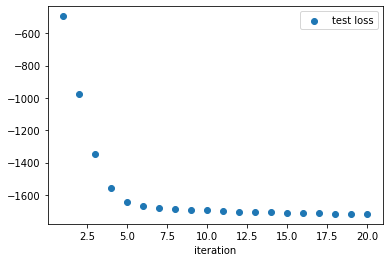

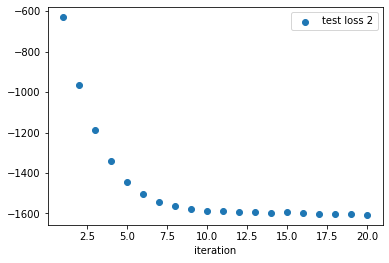

In [16]:
import numpy as np
import torch.optim as optim

train_dataset = datasets.MNIST(
  root = 'data',
  train = True,                         
  transform = ToTensor(), 
  download = True,            
  )
test_dataset = datasets.MNIST(
  root = 'data', 
  train = False, 
  transform = ToTensor()
  )
# define the data loaders
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=400, shuffle=True)
test_data = torch.utils.data.DataLoader(test_dataset, batch_size=400)

# define the model
model1 = VAE()
model2 = VAE()

# define the optimizer
optimizer = optim.Adam(model1.parameters(), lr=0.005)

# Copy weights for fair comparison
copy_weights(model1, model2)

# track the training and test loss
training_loss = []
test_loss = []

training_loss2 = []
test_loss2 = []

mv = None
vv = None
t = 0

# optimize parameters for 20 epochs
for i in range(20):

    # for each minibatch
    for x, _ in train_data:
        x = x.reshape(400,28*28)
        # evaluate the cost function on the training data set
        #loss_1, loss_2, X_dec_1, X_dec_2, Z_1, Z_2, Z_logsigma_1, Z_logsigma_2, epsi = multi_cost_function(x, model1, model2)
        loss_1, xtrash, ztrash, trash = cost_function(x, model1)

        # update the statistics
        #training_loss.append(loss_1.item())
        #print(f"Training loss {loss.item(): 9.3f}")
        #test_loss.append(float('nan'))

        # perform backpropagation
        loss_1.backward()

        # manual
        loss_2, X_dec_2, Z_2, Z_logsigma_2, epsi = cost_function_2(x, model2)

        dec_h1 = F.relu(model2.decoder_fc1(Z_2))
        dec_params = backprop_decoder(x, model2, X_dec_2, dec_h1, Z_2, Z_logsigma_2, epsi)
        enc_h1 = F.relu(model2.encoder_fc1(x))
        enc_params = backprop_encoder(x, model2, enc_h1, dec_params[0], dec_params[1])
        mv, vv, t = adam_optimizer(model2, dec_params, enc_params, lr = 0.005, m=mv, v=vv)

        #training_loss2.append(loss_2.item())
        #print(f"Training loss 2 {loss2.item(): 9.3f}")
        #test_loss2.append(float('nan'))

        # perform a gradient descent step
        optimizer.step()
        
        # reset the gradient information
        optimizer.zero_grad()
        
    # evaluate the model after every epoch
    with torch.no_grad():

        # evaluate the cost function on the test data set
        accumulated_loss = 0
        accumulated_loss2 = 0
        for x, _ in test_data:
            x = x.reshape(400,28*28)
            #loss_1, loss_2, X_dec_1, X_dec_2, Z_1, Z_2, Z_logsigma_1, Z_logsigma_2, dec_h1, enc_h1 = multi_cost_function(x, model1, model2)
            loss_1, xtrash,ztrash, zlog_trash = cost_function(x, model1)
            loss_2, X_decoding, z, zlogsig = cost_function(x, model2)
            accumulated_loss += loss_1.item()
            accumulated_loss2 += loss_2.item()
            
        # update statistics
    test_loss.append(accumulated_loss / len(test_data))
    test_loss2.append(accumulated_loss2 / len(test_data))
            
    print(f"Epoch: {i}, test loss {test_loss[i]: 9.3f}")
    print(f"Epoch: {i}, test loss 2 {test_loss2[i]: 9.3f}")
        
# plot loss
plt.figure()
iterations = np.arange(1, len(test_loss) + 1)
#plt.scatter(iterations, training_loss, label='training loss')
plt.scatter(iterations, test_loss, label='test loss')
plt.legend()
plt.xlabel('iteration')
plt.show()

plt.figure()
iterations = np.arange(1, len(test_loss2) + 1)
#plt.scatter(iterations, training_loss2, label='training loss 2')
plt.scatter(iterations, test_loss2, label='test loss 2')
plt.legend()
plt.xlabel('iteration')
plt.show()

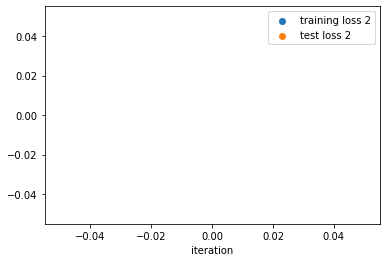

In [17]:
plt.figure()
iterations = np.arange(1, len(training_loss2[40:]) + 1)
plt.scatter(iterations, training_loss2[40:], label='training loss 2')
plt.scatter(iterations, test_loss2[40:], label='test loss 2')
plt.legend()
plt.xlabel('iteration')
plt.show()

## Task 7

Read through and try to understand the implementation of the training procedure above. How does it differ from the implementation of the training procedure of the nonlinear model without encoder?

In contrast to the regular nonlinear model without encoder, we can encode the images of the MNIST data set and repeat the same analysis as for the PPCA model.

In [18]:
model = model2

In [19]:
print(np.shape(train_data.dataset.data))
print(np.shape(train_data.dataset.data))
print(np.shape(test_dataset.data))
print(np.shape(train_data.dataset.targets))

torch.Size([60000, 28, 28])
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([60000])


In [20]:


with torch.no_grad():
    # compute representative encoding of the training images
    train_encoding, _ = model1.encode(train_data.dataset.data.reshape(60000,28*28)/255.0)

    # compute representative encoding of the test images
    test_encoding, _ = model1.encode(test_images.data.reshape(10000,28*28)/255.0)

with torch.no_grad():
    # compute representative encoding of the training images
    train_encoding2, _ = model2.encode(train_data.dataset.data.reshape(60000,28*28)/255.0)

    # compute representative encoding of the test images
    test_encoding2, _ = model2.encode(test_images.data.reshape(10000,28*28)/255.0)

We visualize the encodings.

In [21]:
print(train_encoding[1])

tensor([-1.6424, -0.0981])


torch.Size([60000, 2])
torch.Size([60000, 2])


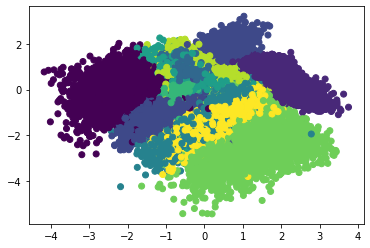

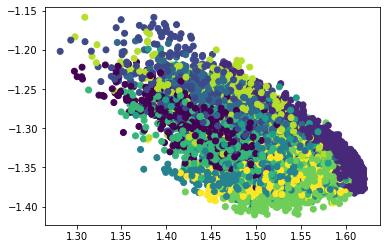

In [22]:
#plot_encoding((train_encoding, train_labels), (test_encoding, test_labels))
print(np.shape(train_encoding))
print(np.shape(train_encoding))
colors = train_labels

plt.scatter(train_encoding[:,0], train_encoding[:,1], c=colors)
plt.show()
colors = test_labels
plt.scatter(test_encoding[:,0], test_encoding[:,1], c=colors)
#plt.scatter(test_encoding[0:,0,0], test_encoding[0:,0,1], c="black", marker="x")
#for tex, enc in zip(test_labels, test_encoding):
#  plt.text(enc[0], enc[1], tex, horizontalalignment='left', size='medium', color='blue', weight='semibold')
#for enc in train_encoding:
#  plt.plot(enc[0], enc[1], '.')

For each of the digits 0, 1, $\ldots$, 9 we compute the average representation in the latent space by taking the mean of the encodings of the MNIST training data set.

In [23]:
# compute mean encoding
#train_mean_encodings = mean_encodings(train_encoding, train_labels)
print(np.shape(np.where(train_labels == 1)))
temp_train = np.asarray(train_encoding)
temp_train2 = np.asarray(train_encoding2)
train_mean_encodings = np.zeros([10,2])
train_mean_encodings2 = np.zeros([10,2])
#train_mean_encodings = []
for i in range(0,10):
  dat = temp_train[np.where(train_labels == i)]
  dat2 = temp_train2[np.where(train_labels == i)]
  x = dat[:,0]
  y = dat[:,1]
  x2 = dat2[:,0]
  y2 = dat2[:,1]
  #train_mean_encodings.append([np.mean(x), np.mean(y)])
  train_mean_encodings[i,0] = np.mean(x)
  train_mean_encodings[i,1] = np.mean(y)
  train_mean_encodings2[i,0] = np.mean(x2)
  train_mean_encodings2[i,1] = np.mean(y2)

(1, 6742)


In [24]:
print(np.shape(train_mean_encodings))

(10, 2)


We visualize their location in the latent space.

C:\Users\LINRY~1.PRE\AppData\Local\Temp/ipykernel_21408/3063936992.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  ax.scatter(train_encoding[ix,0], train_encoding[ix,1], c = cdict[g], label = g, marker='.', alpha=0.5)


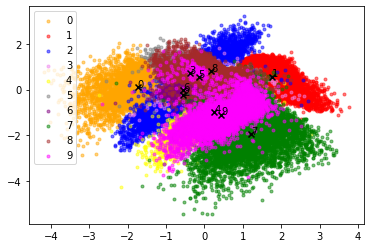

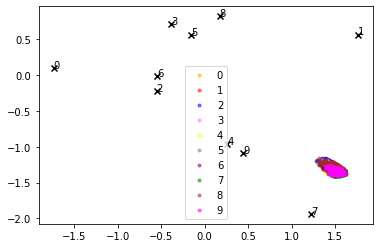

In [25]:
cdict = {0: 'orange', 1: 'red', 2: 'blue', 3: 'violet', 4: 'yellow', 5: 'grey', 6: 'purple', 7: 'green', 8: 'brown', 9: 'magenta'}
n = [0,1,2,3,4,5,6,7,8,9]

fig, ax = plt.subplots()
for g in np.unique(train_labels):
    ix = np.where(train_labels == g)
    ax.scatter(train_encoding[ix,0], train_encoding[ix,1], c = cdict[g], label = g, marker='.', alpha=0.5)
ax.legend()
plt.scatter(train_mean_encodings[:,0],train_mean_encodings[:,1], color='black', marker='x')

for i, txt in enumerate(n):
    ax.annotate(txt, (train_mean_encodings[i,0], train_mean_encodings[i,1]))
plt.show()

fig, ax = plt.subplots()
for g in np.unique(test_labels):
    ix = np.where(test_labels == g)
    ax.scatter(test_encoding[ix,0], test_encoding[ix,1], c = cdict[g], label = g, marker='.', alpha=0.5)
ax.legend()
plt.scatter(train_mean_encodings[:,0],train_mean_encodings[:,1], color='black', marker='x')

for i, txt in enumerate(n):
    ax.annotate(txt, (train_mean_encodings[i,0], train_mean_encodings[i,1]))
plt.show()



Of course, we can also decode the latent encodings with our model.

tensor(1.0235)
tensor(0.9675)


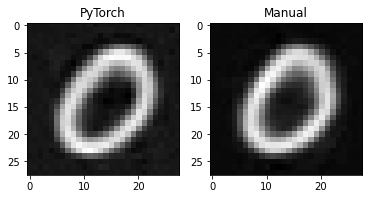

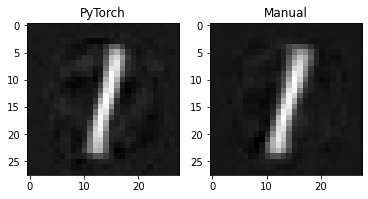

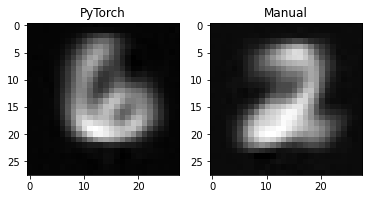

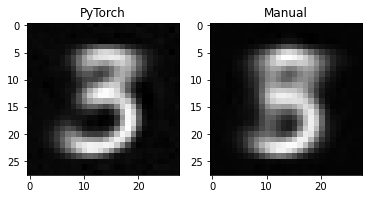

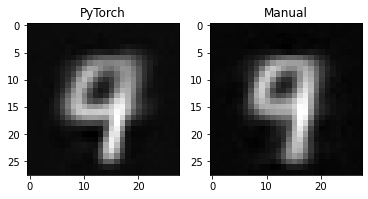

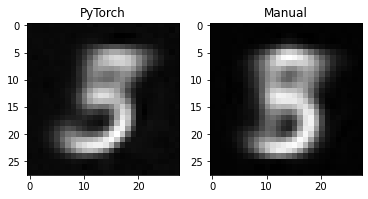

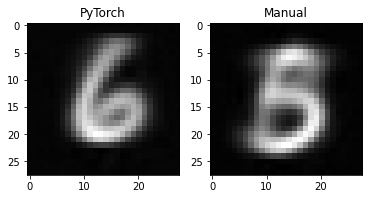

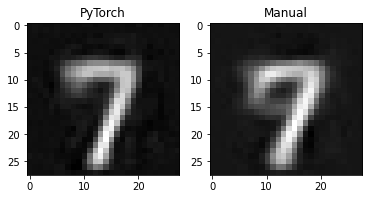

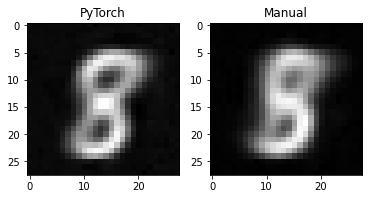

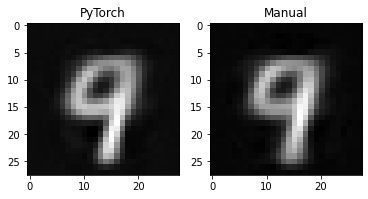

In [26]:
with torch.no_grad():
    # compute representative encoding of the training images
    train_encoding, _ = model1.encode(train_data.dataset.data.reshape(60000,28*28)/255.0)

    # compute representative encoding of the test images
    test_encoding, _ = model1.encode(test_images.data.reshape(10000,28*28)/255.0)

with torch.no_grad():
    # compute representative encoding of the training images
    train_encoding2, _ = model2.encode(train_data.dataset.data.reshape(60000,28*28)/255.0)

    # compute representative encoding of the test images
    test_encoding2, _ = model2.encode(test_images.data.reshape(10000,28*28)/255.0)

temp_train = np.asarray(train_encoding)
temp_train2 = np.asarray(train_encoding2)
train_mean_encodings = np.zeros([10,2])
train_mean_encodings2 = np.zeros([10,2])
#train_mean_encodings = []
for i in range(0,10):
  dat = temp_train[np.where(train_labels == i)]
  dat2 = temp_train2[np.where(train_labels == i)]
  x = dat[:,0]
  y = dat[:,1]
  x2 = dat2[:,0]
  y2 = dat2[:,1]
  #train_mean_encodings.append([np.mean(x), np.mean(y)])
  train_mean_encodings[i,0] = np.mean(x)
  train_mean_encodings[i,1] = np.mean(y)
  train_mean_encodings2[i,0] = np.mean(x2)
  train_mean_encodings2[i,1] = np.mean(y2)

# compute mean images
train_mean_tensor = torch.tensor(train_mean_encodings)
train_mean_tensor2 = torch.tensor(train_mean_encodings2)

with torch.no_grad():
    train_mean_images = model1.decode(train_mean_tensor.float())
    train_mean_images2 = model2.decode(train_mean_tensor2.float())

#plot_images(train_mean_images, torch.arange(10))
print(max(train_mean_images[1]))
print(max(train_mean_images2[1]))

  #print(np.shape(img.reshape(28,28)))
for img1, img2 in zip(train_mean_images, train_mean_images2):
  numimg1 = img1.reshape(28,28)
  numimg2 = img2.reshape(28,28)

  f, axarr = plt.subplots(1,2)
  axarr[0].set_title(f"PyTorch")
  axarr[0].imshow(numimg1, cmap='gray')
  axarr[1].set_title("Manual")
  axarr[1].imshow(numimg2, cmap='gray')
  plt.show()

Let us get a feeling for the distribution in the latent space by defining and analysing a whole grid of encodings, spanned by the mean encodings of the digits "0" and "9".

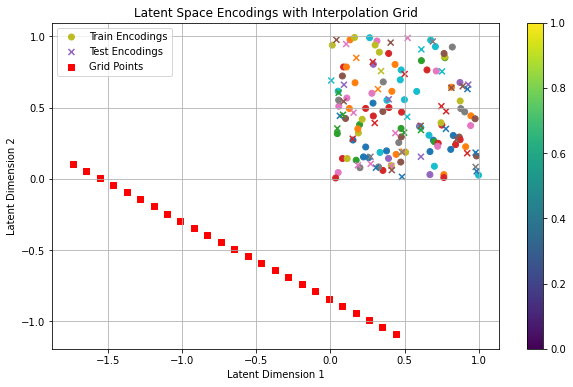

In [39]:
# Example mean encodings for demonstration; replace with your actual encodings
mean_encoding_0 = np.array([1, 2])  # Placeholder vector for "0"
mean_encoding_9 = np.array([3, 4])  # Placeholder vector for "9"

# Create a grid of points between these two encodings
def create_linear_interpolation(start, end, n_points):
    # Linearly interpolate between start and end vectors
    return np.linspace(start, end, n_points)

n_points = 5*5  # Number of points in the grid
zgrid = create_linear_interpolation(train_mean_encodings[0], train_mean_encodings[9], n_points)

# Assuming train_encoding, train_labels, test_encoding, test_labels are available
# You might need to adjust this code to fit your data structures

def plot_encodings(train_encodings, train_labels, test_encodings, test_labels, grid):
    plt.figure(figsize=(10, 6))
    
    # Plot train encodings
    plt.scatter(train_encodings[:, 0], train_encodings[:, 1], c=train_labels, cmap='tab10', label='Train Encodings')
    
    # Plot test encodings
    plt.scatter(test_encodings[:, 0], test_encodings[:, 1], c=test_labels, cmap='tab10', marker='x', label='Test Encodings')
    
    # Plot grid points
    plt.scatter(grid[:, 0], grid[:, 1], color='red', marker='s', label='Grid Points')
    
    plt.colorbar()
    plt.legend()
    plt.grid(True)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Encodings with Interpolation Grid')
    plt.show()

# Example placeholders for train/test encodings and labels; replace with your actual data
train_encodings = np.random.rand(100, 2)  # 100 points, 2D for simplicity
train_labels = np.random.randint(0, 10, 100)  # Random labels for demonstration
test_encodings = np.random.rand(50, 2)  # 50 points, 2D
test_labels = np.random.randint(0, 10, 50)  # Random labels

# Visualize
plot_encodings(train_encodings, train_labels, test_encodings, test_labels, zgrid)


We show the corresponding decoded images.

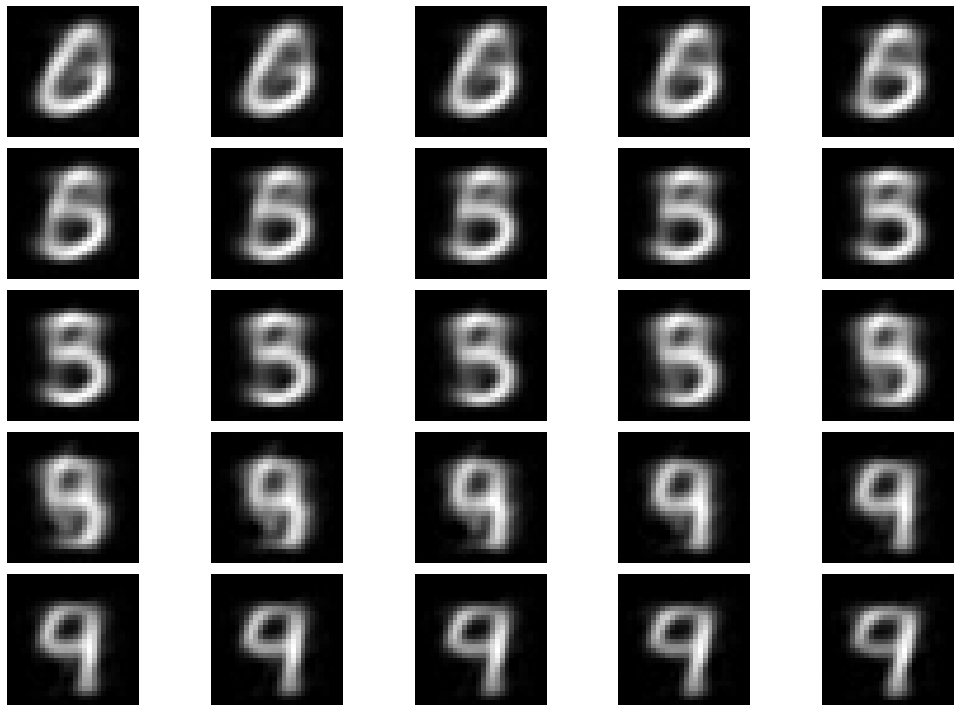

In [40]:
# Ensure zgrid is a PyTorch tensor
zgrid_tensor = torch.from_numpy(zgrid).float()  # Convert zgrid to a PyTorch tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use the model to decode the grid of latent vectors
with torch.no_grad():
    xgrid = model.decode(zgrid_tensor.to(device))  # Ensure zgrid_tensor is on the same device as the model

def plot_images(images, grid_size=(10, 1), figsize=(10, 1)):
    """
    Plots a grid of images.

    Parameters:
    - images: PyTorch tensor of shape (N, C, H, W)
    - grid_size: Tuple indicating the grid size, e.g., (rows, columns)
    - figsize: Figure size
    """
    fig, axs = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=figsize,
                            subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axs.flat):
        img = images[i].cpu().detach().numpy()  # Convert the tensor to a NumPy array
        #img = np.transpose(img, (1, 2, 0))  # Change from (C, H, W) to (H, W, C)
        img = np.clip(img, 0, 1)  # Ensure the image values are valid
        img = img.reshape(28,28)
        ax.imshow(img, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming xgrid is a tensor of shape (N, C, H, W), where
# N is the number of images, C is the number of channels, and H, W are the height and width
# Adjust grid_size accordingly if you have more images
plot_images(xgrid, grid_size=(5, 5), figsize=(15, 10))  # Adjust grid size and figure size as needed


As in the previous parts of the lab session, we also compare the test images with their reconstructions to see how much information we lose by encoding the MNIST images in a two-dimensional space. We plot a set of images and their reconstructions, and compute the average squared reconstruction error as a more objective measure.

In [ ]:
# compute reconstruction
with torch.no_grad():
    test_reconstruction = model.decode(test_encoding)

# compute average squared reconstruction error
sqerr = (test_images - test_reconstruction).pow(2).sum(dim=1).mean()
print(f"Average squared reconstruction error: {sqerr}")

plot_reconstruction(test_images, test_reconstruction, test_labels)

## Task 8

Now we have performed exactly the same analysis as for the regular and the probabilistic PCA. Compare your results and answer Questions 4.8, 4.9, and 4.10 in the lab instructions.

We can also generate new MNIST-like images in the same way as for the nonlinear model without encoder. Again we sample 25 vectors $\mathbf{z}_1, \ldots, \mathbf{z}_{25}$ from $\mathcal{N}(0, \mathbf{I}_{2})$, and plot the representative decoding $\mu_{\boldsymbol{\theta}}(\mathbf{z}_n)$.

In [ ]:
with torch.no_grad():
  x = sample_decode(model, 25)

plot_images(x)

## Summary

We have trained a variational autoencoder that allows us to generate MNIST-like images. Adding a nonlinearity and an encoder seems to improve the quality of the samples. However, we also notice that the model is not perfect. Many further modifications of the decoder and encoder models are possible and could potentially improve the sampler. For instance, the dimension of the latent space can be increased (then the information loss by encoding the images in the latent space should be reduced). Alternatively the nonlinear decoder model can be changed: a more flexible model with increased number of layers in the neural network or a diagonal (or even full) covariance matrix could be used, or the outputs could be restricted to values between 0 and 1 (since we represent MNIST images as vectors with entries between 0 and 1).